## Deep Determenistic Policy Gradients
Work in progress nut it will be finished soon enough

Special thanks to KnightofK9

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle
import json
import h5py

# on my system os error often pops up
# try to open the file explorer and copy paste the path again 
f = h5py.File("/media/dev/New Volume/projects/RecNN/static_dataset.hdf5", "r")
cuda = torch.device('cuda')
frame_size = 10

# Model

In [3]:
class StateRepresentation(nn.Module):
    def __init__(self):
        super(StateRepresentation, self).__init__()
        self.lin = nn.Sequential(
            # 128 - embed size, 1 - rating size
            nn.Linear(frame_size * (128 + 1), 256),
            nn.Tanh(),
        )
        
    def forward(self, state):
        # apply state represemtation module
        state = self.lin(state)
        return state

In [4]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(Actor, self).__init__()
        
        # self.state_rep = StateRepresentation()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        # state = self.state_rep(state)
        x = F.relu(self.linear1(state))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x
    

In [5]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

## DDPG Code
[Creditals](https://github.com/higgsfield/RL-Adventure-2/blob/master/5.ddpg.ipynb)

Note: in order to prevent exploitation I am using custom loss function for policy optimization. The ddpg algorithm often uses policy_loss = - policy_loss.mean(), however since that we are working in a static environment we know that the reward cannot surpass max value. When it does so, the action is automatically rulled exploitation and additional loss is added.

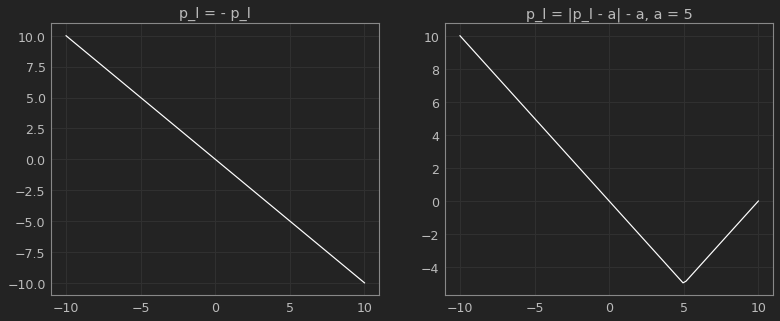

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

x = np.linspace(-10, 10, 100)
a = 5
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('p_l = - p_l')
plt.plot(x, -x, '-w')
plt.subplot(132)
plt.title('p_l = |p_l - a| - a, a = 5')
plt.plot(x, abs(x - a) - a, '-w')
plt.show()

In [14]:
#load movies
import pickle 
movies = pickle.load(open('../data/infos_pca128.pytorch', 'rb'))
true_actions = torch.stack([movies[i] for i in movies]).to(cuda)
del movies

@torch.jit.script
def torch_cdist_euc(x1, x2):
    x1_norm = x1.pow(2).sum(dim=-1, keepdim=True)
    x2_norm = x2.pow(2).sum(dim=-1, keepdim=True)
    res = torch.addmm(x2_norm.transpose(-2, -1), x1, x2.transpose(-2, -1), alpha=-2).add_(x1_norm)
    res = res.clamp_min_(1e-30).sqrt_()
    return res

# cossim works fine
# with
@torch.jit.script
def torch_cdist_cos(x1, x2):
    x1_norm = x1 / x1.norm(dim=1, p=2).unsqueeze(1)
    x2_norm = x2 / x2.norm(dim=1, p=2).unsqueeze(1)
    res = 1 - torch.mm(x1_norm, x2_norm.transpose(0,1))
    return res

In [15]:
debug_state = None
debug_action = None
debug_gen_action = None

def f_policy_loss(state, gen_action, max_value, dist_f=torch_cdist_euc):
    policy_loss = value_net(state, gen_action)
    c_d =  dist_f(gen_action, gen_action)
    c_d = torch.max(torch.eye(gen_action.size(0)).to(cuda), c_d) # get rid of eye zeros
    policy_loss = torch.abs(policy_loss.mean() - max_value) - max_value
    policy_loss += c_d.mean()
    
    return policy_loss, c_d.mean()

def ddpg_update(batch, gamma = 0.99, min_value=-5,max_value=5,
           soft_tau=1e-2, debug=False, learn=True):
    
    state, action, reward, next_state, done = batch
    
    if not learn:
        [net.eval() for net in nets]
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    gen_action = policy_net(state)
    
    policy_loss, c_d = f_policy_loss(state, gen_action, max_value)
    
    next_action = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)
    
    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())
    
    if debug:
        global debug_state
        global debug_action
        global debug_gen_action
        debug_state = state
        debug_action = action
        debug_gen_action = gen_action 

    if not learn:
        # used for testing
        [net.train() for net in nets]
        losses = [value_loss.item(), policy_loss.item()]
        return losses
    
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
    losses = [value_loss.item(), policy_loss.item(), c_d.item()]
    return losses

In [16]:
#value_net  = Critic(256, 128, 320).to(cuda)
#policy_net = Actor(256, 128, 192).to(cuda)

#target_value_net  = Critic(256, 128, 320).to(cuda)
#target_policy_net = Actor(256,128, 192).to(cuda)

value_net  = Critic(1290, 128, 320).to(cuda)
policy_net = Actor(1290, 128, 192).to(cuda)

target_value_net  = Critic(1290, 128, 320).to(cuda)
target_policy_net = Actor(1290,128, 192).to(cuda)


nets =[policy_net, target_policy_net, value_net, target_value_net]

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 10e-5
policy_lr = 10e-6

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
value_criterion = nn.MSELoss()

In [17]:
#from tensorboardX import SummaryWriter
#writer = SummaryWriter('../runs/')

In [18]:
from IPython.display import clear_output

def run_tests():
    test_batch = [f[key][n_batches-1*batch_size:(n_batches)*batch_size] for key in
                 ['state', 'action', 'reward', 'next_state', 'done']]
    test_batch = prepare_batch(*test_batch)
    losses = ddpg_update(test_batch, debug=True, learn=False)
    return losses
    

# value, policy, step
test_losses = [[], [], [], []]
def plot(value_losses, policy_losses, c_d, test=True):
    global test_losses
    if test:
        test_ = run_tests()
        test_losses[0].append(test_[0])
        test_losses[1].append(test_[1])
        test_losses[2].append(len(value_losses))
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('value')
    plt.plot(value_losses, label='train')
    plt.plot(test_losses[2], test_losses[0], '-r', label='test')
    plt.subplot(132)
    plt.title('policy')
    plt.plot(policy_losses, label='train')
    plt.plot(c_d, label='cosine dist')
    plt.plot(test_losses[2], test_losses[1], '-r', label='test')
    plt.legend()
    plt.show()

In [19]:
value_losses = []
policy_losses = []
c_d_losses = []

n_epochs = 3
batch_size = 5000
n_batches = (f['state'].shape[0] // batch_size)

batch_bar = tqdm(total=n_batches)
epoch_bar = tqdm(total=n_epochs)

# Training

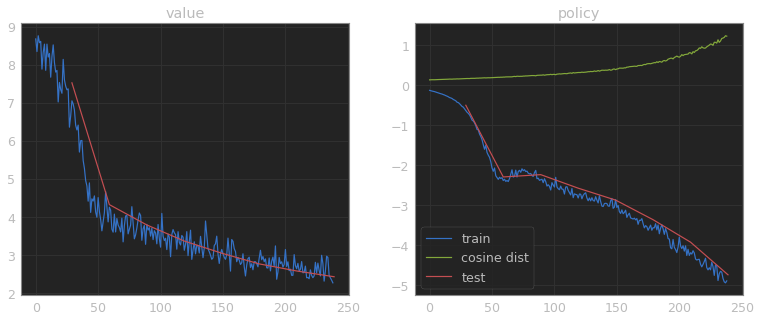

KeyboardInterrupt: 

In [20]:
def prepare_batch(*args):
    args = [torch.tensor(np.array(arg).astype(np.float)).to(cuda).float() for arg in args]
    return args

DEBUG = True

batch = []
plot_every = 30
b_idx = 1
for epoch in range(n_epochs):
    epoch_bar.update(1)
    for i in range(n_batches-1):
        b_idx += 1
        batch_bar.update(1)
        batch = [f[key][i*batch_size:(i+1)*batch_size] for key in
                 ['state', 'action', 'reward', 'next_state', 'done']]
        batch = prepare_batch(*batch)
        
        loss = ddpg_update(batch, debug=DEBUG)
        value_losses.append(loss[0])
        policy_losses.append(loss[1])
        c_d_losses.append(loss[2])
        
        batch = []
        
        # debug plotting
        if b_idx % plot_every == 0:
            plot(value_losses, policy_losses, c_d_losses)
            
    batch_bar.refresh()

In [89]:
#torch.save(target_value_net.state_dict(), "../models/value.pt")
#torch.save(target_policy_net.state_dict(), "../models/policy.pt")

In [24]:
# plot(value_losses, policy_losses, test=True)
len(test_losses[3])

0

# Debug here

In [417]:
# you can debug here
debug_state 
debug_gen_actions[1]

tensor([ 0.3310, -0.2944,  0.2846, -0.5582, -0.2088,  0.1239, -0.3277,  0.3876,
         0.9231, -0.8204, -0.5073, -0.7075, -0.6337, -0.4281,  0.1756,  0.3590,
        -0.2226,  0.3647, -0.4834,  0.1017, -0.0518,  0.2899,  0.5391,  0.2041,
         0.1724, -0.2771,  0.4784, -0.1405, -0.3302, -0.2841, -0.0026, -0.0508,
        -0.1806,  0.2917,  0.1181,  0.4140, -0.0143,  0.2782,  0.2233, -0.6062,
         0.1719, -0.3190, -0.1124, -0.0979, -0.1394,  0.4057,  0.2390,  0.2888,
        -0.2376,  0.1051, -0.2375,  0.1852, -0.3155, -0.1202, -0.0588, -0.0221,
        -0.1421, -0.2822, -0.2640, -0.0399,  0.3270, -0.0117, -0.3135,  0.4061,
         0.0956, -0.2345, -0.1163,  0.0200,  0.2767, -0.1888,  0.2129, -0.1204,
        -0.0662, -0.0947, -0.0522, -0.0666,  0.0346,  0.0871, -0.1405,  0.0685,
         0.0135,  0.2250, -0.3173,  0.2670,  0.1133,  0.1932,  0.2778,  0.1141,
        -0.4193,  0.0102,  0.1307,  0.2735, -0.1136, -0.1072,  0.3250,  0.1237,
         0.3599, -0.3074, -0.0965, -0.11

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


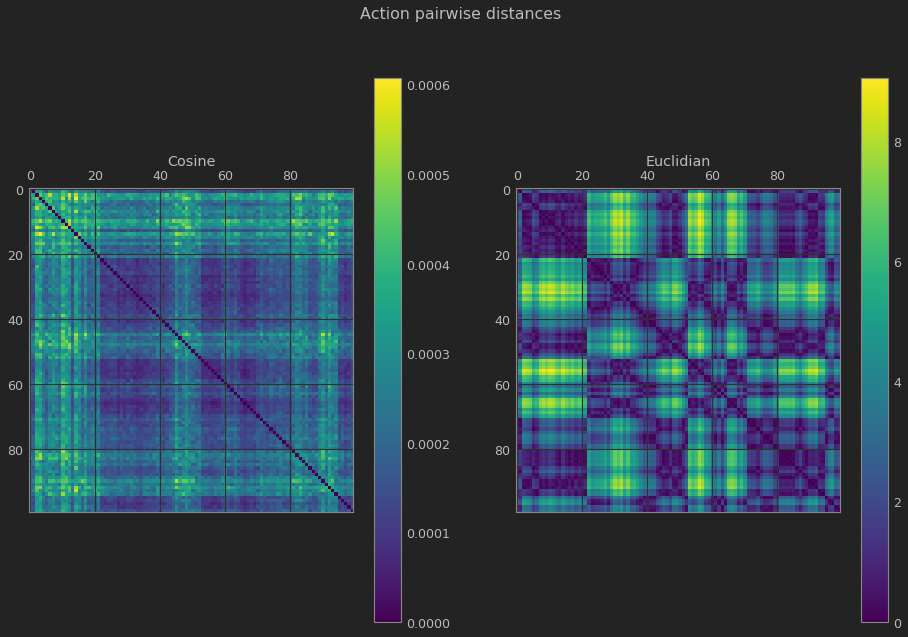

In [418]:
from scipy.spatial import distance

embs = debug_gen_action[:100].detach().cpu().numpy()
similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121)
cax = ax.matshow(similarity_matrix_cos)
fig.colorbar(cax)
ax.set_title('Cosine')

ax = fig.add_subplot(122)
cax = ax.matshow(similarity_matrix_euc)
fig.colorbar(cax)
ax.set_title('Euclidian')


fig.suptitle('Action pairwise distances')
fig.show()

# Test here

In [132]:
import pickle 
from scipy.spatial import distance
movies = pickle.load(open('../data/infos_pca128.pytorch', 'rb'))
true_actions = np.stack([movies[i] for i in movies])
infos_web = json.load(open('../data/infos.json'))

# action is set here!

debug_gen_actions = debug_gen_action
debug_gen_action = debug_gen_actions[1632].detach().cpu().numpy()

genres_dict = {'Animation': 16,
 'Comedy': 35,
 'Family': 10751,
 'Adventure': 12,
 'Fantasy': 14,
 'Romance': 10749,
 'Drama': 18,
 'Action': 28,
 'Crime': 80,
 'Thriller': 53,
 'Horror': 27,
 'History': 36,
 'Science Fiction': 878,
 'Mystery': 9648,
 'War': 10752,
 'Music': 10402,
 'Documentary': 99,
 'Western': 37,
 'TV Movie': 10770,
 'Sport': 1,
 'Sci-Fi': 878,
 'Musical': 10402,
 'Short': 2,
 'News': 3,
 'Film-Noir': 4}
genres_dict = {v: k for k, v in genres_dict.items()}

## Lets see what we get
### Euclidian Distance

In [44]:
scores = []
for i in movies.keys():
    scores.append([i, distance.euclidean(movies[i], debug_gen_action)])
scores = list(sorted(scores, key = lambda x: x[1]))
#scores = scores[:10]
#ids = [i[0] for i in scores]
#for i in range(10):
#    scores[i].extend([infos_web[str(scores[i][0])][key]  for key in ['title',
#                            'genres', 'original_language', 'release_year', 'vote_average']])
#    scores[i][3] = ' '.join([genres_dict[i] for i in scores[i][3]])
#    
#indexes = ['id', 'score', 'title', 'genres', 'language', 'year', 'rating']
#table_dict = dict([(key,[i[idx] for i in scores]) for idx, key in enumerate(indexes)])
#table = pd.DataFrame(table_dict)
scores

[[83976, 8.787109375],
 [4256, 8.796648025512695],
 [959, 8.8115234375],
 [4432, 8.972845077514648],
 [70659, 9.021621704101562],
 [3217, 9.046510696411133],
 [3011, 9.078237533569336],
 [1498, 9.12671947479248],
 [104089, 9.129339218139648],
 [8410, 9.176023483276367],
 [102167, 9.240213394165039],
 [99220, 9.2559175491333],
 [81, 9.256110191345215],
 [70889, 9.26146411895752],
 [6830, 9.2722749710083],
 [33288, 9.276869773864746],
 [6953, 9.283787727355957],
 [120631, 9.286026954650879],
 [2726, 9.30411434173584],
 [33145, 9.305688858032227],
 [483, 9.306018829345703],
 [45658, 9.317903518676758],
 [48575, 9.324995040893555],
 [44881, 9.348404884338379],
 [47836, 9.361105918884277],
 [83357, 9.37179183959961],
 [26070, 9.374600410461426],
 [108493, 9.38195514678955],
 [2356, 9.390921592712402],
 [77816, 9.417947769165039],
 [104518, 9.421378135681152],
 [5015, 9.42474365234375],
 [26141, 9.42707347869873],
 [5619, 9.430091857910156],
 [7474, 9.435066223144531],
 [88823, 9.44164466857

In [40]:
table

,id,score,title,genres,language,year,rating
0,83976,8.787109,The Trip,Comedy Drama,en,2010,7.0
1,4256,8.796648,The Center of the World,Drama Romance,en,2001,5.3
2,959,8.811523,Of Human Bondage,Drama,en,1934,6.9
3,4432,8.972845,Sweet Smell of Success,Drama,en,1957,7.7
4,70659,9.021622,The Great Happiness Space: Tale of an Osaka Lo...,Documentary,en,2006,7.3
5,3217,9.046511,A Star Is Born,Drama Romance,en,1937,6.9
6,3011,9.078238,"They Shoot Horses, Don't They?",Drama,en,1969,7.8
7,1498,9.126719,Inventing the Abbotts,Drama Romance,en,1997,6.1
8,104089,9.129339,Computer Chess,Comedy,en,2013,6.3
9,8410,9.176023,Suddenly,Crime Drama Thriller,en,1954,6.5


/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


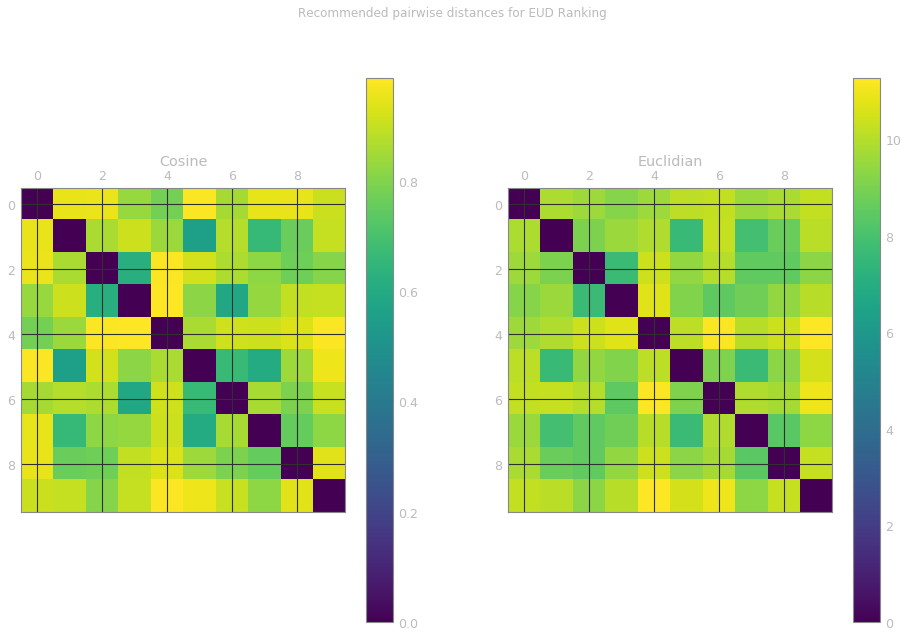

In [41]:
embs = np.stack([movies[i].numpy() for i in ids])
similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121)
cax = ax.matshow(similarity_matrix_cos)
fig.colorbar(cax)
ax.set_title('Cosine')

ax = fig.add_subplot(122)
cax = ax.matshow(similarity_matrix_euc)
fig.colorbar(cax)
ax.set_title('Euclidian')


fig.suptitle('Recommended pairwise distances for EUD Ranking')
fig.show()

### Cosine Distance

In [42]:
scores = []
for i in movies.keys():
    scores.append([i, distance.cosine(movies[i], debug_gen_action)])
scores = list(sorted(scores, key = lambda x: x[1]))
scores = scores[:10]
ids = [i[0] for i in scores]
for i in range(10):
    scores[i].extend([infos_web[str(scores[i][0])][key]  for key in ['title',
                            'genres', 'original_language', 'release_year', 'vote_average']])
    scores[i][3] = ' '.join([genres_dict[i] for i in scores[i][3]])
    
indexes = ['id', 'score', 'title', 'genres', 'language', 'year', 'rating']
table_dict = dict([(key,[i[idx] for i in scores]) for idx, key in enumerate(indexes)])
table = pd.DataFrame(table_dict)

In [43]:
table

,id,score,title,genres,language,year,rating
0,296,0.631209,Pulp Fiction,Thriller Crime,en,1994,8.4
1,112183,0.637883,Birdman,Drama Comedy,en,2014,7.4
2,47,0.645337,Se7en,Crime Mystery Thriller,en,1995,8.3
3,50,0.663538,The Usual Suspects,Drama Crime Thriller,en,1995,8.2
4,45517,0.664232,Cars,Animation Adventure Comedy Family,en,2006,6.7
5,3011,0.665532,"They Shoot Horses, Don't They?",Drama,en,1969,7.8
6,8340,0.666805,Escape from Alcatraz,Crime Drama,en,1979,7.4
7,70659,0.680552,The Great Happiness Space: Tale of an Osaka Lo...,Documentary,en,2006,7.3
8,115569,0.682142,Nightcrawler,Crime Drama Thriller,en,2014,7.7
9,5989,0.683048,Catch Me If You Can,Drama Crime,en,2002,7.9


/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


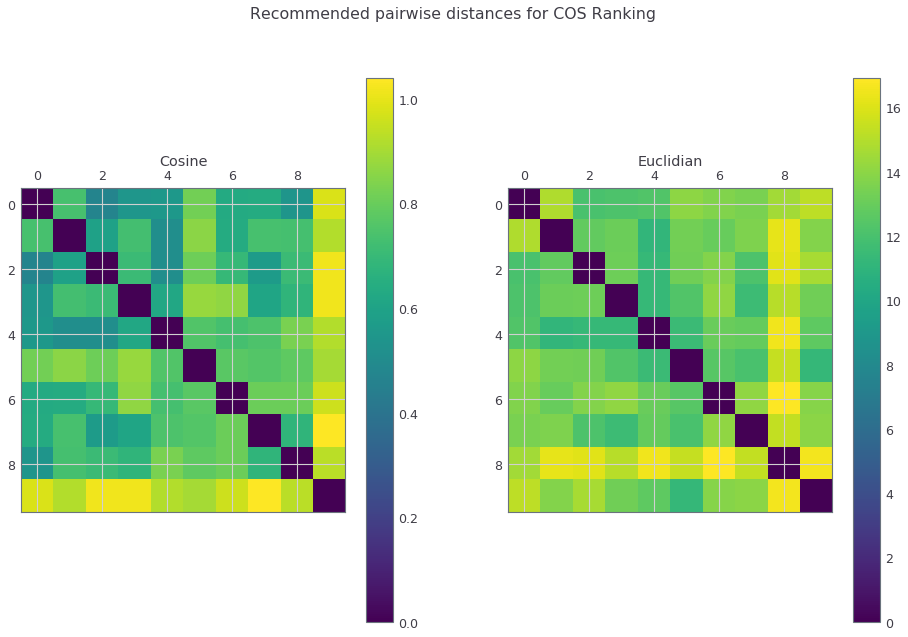

In [101]:
embs = np.stack([movies[i].numpy() for i in ids])
similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121)
cax = ax.matshow(similarity_matrix_cos)
fig.colorbar(cax)
ax.set_title('Cosine')

ax = fig.add_subplot(122)
cax = ax.matshow(similarity_matrix_euc)
fig.colorbar(cax)
ax.set_title('Euclidian')
fig.suptitle('Recommended pairwise distances for COS Ranking')
fig.show()

## Bonus: compute Wasserstein Distance for actions

In [242]:
from scipy.special import kl_div
gen_actions = debug_gen_actions
true_actions = np.stack([movies[i] for i in movies])

In [243]:
class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.ae = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.ae(x)
    
    def rec_error(self, x):
        error = torch.sum((x - self.ae(x)) ** 2, 1)
        if x.size(1) != 1:
            return error.detach()
        return error.item()

In [244]:
ad = AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../models/anomaly.pt'))
ad.eval()

AnomalyDetector(
  (ae): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=64, out_features=128, bias=True)
    (10): ReLU()
  )
)

In [245]:
true_scores = ad.rec_error(torch.tensor(true_actions).to(cuda).float()).detach().cpu().numpy()
gen_scores = ad.rec_error(torch.tensor(gen_actions).to(cuda).float()).detach().cpu().numpy()

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


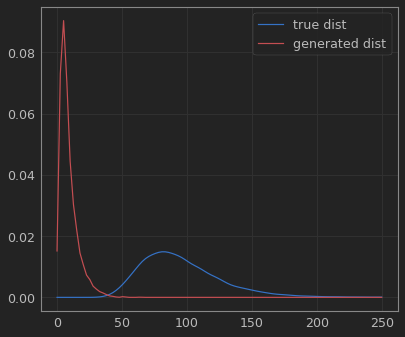

In [246]:
from scipy import stats

true_kernel = stats.gaussian_kde(true_scores)
gen_kernel = stats.gaussian_kde(gen_scores)
x = np.linspace(0,250, 100)
probs_true = true_kernel(x)
probs_gen = gen_kernel(x)
plt.plot(x, probs_true, '-b', label='true dist')
plt.plot(x, probs_gen, '-r', label='generated dist')
plt.legend()
plt.show()

In [164]:
stats.wasserstein_distance(true_scores, gen_scores)

53.58498535774933